# Basic CNN — Example Notebook

Part of the **Computer Vision Examples** project by [Nicola Mustone](https://nicolamustone.blog).  
Licensed under the [GNU General Public License v3.0 (GPLv3)](https://www.gnu.org/licenses/gpl-3.0.html).

This notebook demonstrates a clean, reproducible workflow for training a **Convolutional Neural Network (CNN)** on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).
It uses **TensorFlow**, **Keras**, and **KerasTuner** to build, train, and optimize a simple CNN for image classification.

## What You’ll Learn

- How to preprocess grayscale image data for CNNs.
- How to build a modular `SimpleCNN` class with reusable blocks.
- How to train a baseline CNN model and visualize results.
- How to use **Bayesian optimization** with KerasTuner for hyperparameter tuning.
- How to evaluate the model using accuracy, loss curves, and confusion matrices.

The workflow is kept compact and reproducible — ideal for experimentation and for future transfer to other small image datasets.

## Environment Setup

We begin by importing all required libraries and confirming that TensorFlow detects available GPUs.

In [1]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from keras_tuner.tuners import BayesianOptimization

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Python version: 3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:14:51) [GCC 14.3.0]
TensorFlow version: 2.20.0
Available GPUs: []


In [2]:
# ====== GLOBAL CONSTANTS ======

# Image dimensions and shape
IMAGE_HEIGHT = 32
IMAGE_WIDTH  = 32
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

# Dataset and model parameters
NUM_CLASSES   = 10
VAL_SPLIT     = 0.3        # portion of data reserved for validation
BATCH_SIZE    = 128
MAX_TRIALS    = 10         # how many configurations the tuner will test
TUNER_EPOCHS  = 5          # short runs during Bayesian optimization
FINAL_EPOCHS  = 10         # full training of the best model

# Reproducibility
SEED = 42

# Apply seed across all major libraries and environments
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Preparation

The [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 60,000 images of 10 different labels (32×32 color images).

Steps:
1. Load and split data into training, validation, and test sets.  
2. Normalize pixel values to the [0, 1] range.  
3. Convert integer labels to one-hot encoding for classification.  
4. Visualize a few samples to verify correctness.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

print("Train full:", X_train_full.shape)
print("Test:", X_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Train full: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [4]:
X_train_full = X_train_full.astype("float32") / 255.0
X_test       = X_test.astype("float32") / 255.0

In [5]:
y_train_full = to_categorical(y_train_full, NUM_CLASSES)
y_test_onehot = to_categorical(y_test, NUM_CLASSES)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_SPLIT,
    random_state=SEED
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (35000, 32, 32, 3)
Validation: (15000, 32, 32, 3)
Test: (10000, 32, 32, 3)


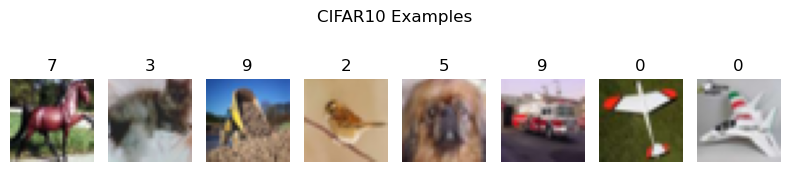

In [22]:
plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(np.argmax(y_train[i]))
plt.suptitle("CIFAR10 Examples")
plt.tight_layout()
plt.show()


## Model Definition — `SimpleCNN`

The `SimpleCNN` class defines a flexible, modular architecture:

- **Conv Block:** `Conv2D → BatchNorm → Activation → MaxPooling2D`
- **Dense Block:** `Dense → BatchNorm → Activation → Dropout`

The network uses a small number of parameters and supports **multi-GPU** training via TensorFlow’s `MirroredStrategy`.

You can adjust:
- Number of filters
- Regularization strength (L2)
- Dropout rate
- Optimizer and learning rate
- Activation function

In [8]:
class SimpleCNN:
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
        self.input_shape = input_shape
        self.num_classes = num_classes
        # Check for multi-GPU
        if len(tf.config.list_physical_devices('GPU')) > 1:
            print("Multiple GPUs detected, using MirroredStrategy.")
            self.strategy = tf.distribute.MirroredStrategy()
        else:
            self.strategy = None
        self.model = None

    def _add_conv_block(self, model, filters, l2_value, activation):
        """Add a Conv2D -> BatchNorm -> Activation -> MaxPool2D block."""
        conv_args = {
            "filters": filters,
            "kernel_size": (3, 3),
            "padding": "same",
            "activation": None,
            "kernel_regularizer": regularizers.l2(l2_value)
        }

        model.add(layers.Conv2D(**conv_args))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.MaxPooling2D((2, 2)))

    def _add_dense_block(self, model, units, l2_value, activation, dropout):
        """Add Dense -> BatchNorm -> Activation -> Dropout block."""
        model.add(layers.Dense(units, activation=None, kernel_regularizer=regularizers.l2(l2_value)))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.Dropout(dropout))

    def build(self, n_filters=32, l2=0.0, lr=1e-3, optimizer='adam', dropout=0.0, activation='relu'):
        model = models.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        
        # First Conv block
        self._add_conv_block(model, n_filters,       l2, activation)
        # Second Conv block
        self._add_conv_block(model, n_filters // 2,  l2, activation)
        model.add(layers.Flatten())
        # Dense block
        self._add_dense_block(model, 64, l2, activation, dropout)
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        opt_cls = getattr(optimizers, optimizer.capitalize())
        if self.strategy:
            with self.strategy.scope():
                self.model = model
                self.model.compile(
                    optimizer=opt_cls(learning_rate=lr),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
        else:
            self.model = model
            self.model.compile(
                optimizer=opt_cls(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

    def summary(self):
        self.model.summary()

    def fit(self, X_train, y_train, X_val, y_val, epochs=FINAL_EPOCHS, batch_size=BATCH_SIZE):
        return self.model.fit(
            X_train, y_train,
            epochs=epochs, batch_size=batch_size,
            validation_data=(X_val, y_val), verbose=2
        )

    def evaluate(self, X, y):
        return self.model.evaluate(X, y, verbose=0)


## Baseline Training

The first run trains the CNN using default parameters to establish a baseline.

We then visualize:
- Training and validation accuracy
- Training and validation loss

This provides a performance reference before tuning hyperparameters.

In [9]:
# --- Baseline model (before optimization) ---
print("\n========= Baseline SimpleCNN Training =========\n")

baseline_cnn = SimpleCNN()
baseline_cnn.build()  # use all defaults (n_filters=32, l2=0.0, lr=1e-3, optimizer='adam', dropout=0.0, activation='relu')
baseline_cnn.summary()


========= Baseline SimpleCNN Training =========



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,218 (282.10 KB)

 Trainable params: 71,994 (281.23 KB)

 Non-trainable params: 224 (896.00 B)

In [10]:
history_base = baseline_cnn.fit(
    X_train, y_train,
    X_val, y_val,
    epochs=FINAL_EPOCHS
)

Epoch 1/10


2025-11-11 14:14:29.535612: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 430080000 exceeds 10% of free system memory.
2025-11-11 14:14:30.323221: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 16777216 exceeds 10% of free system memory.
2025-11-11 14:14:30.325813: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 16777216 exceeds 10% of free system memory.
2025-11-11 14:14:30.327902: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 16777216 exceeds 10% of free system memory.
2025-11-11 14:14:30.335941: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 28311552 exceeds 10% of free system memory.


274/274 - 6s - 21ms/step - accuracy: 0.5010 - loss: 1.4127 - val_accuracy: 0.1830 - val_loss: 2.9543
Epoch 2/10
274/274 - 5s - 18ms/step - accuracy: 0.6309 - loss: 1.0500 - val_accuracy: 0.4581 - val_loss: 1.5535
Epoch 3/10
274/274 - 5s - 18ms/step - accuracy: 0.6800 - loss: 0.9121 - val_accuracy: 0.4714 - val_loss: 1.5763
Epoch 4/10
274/274 - 5s - 18ms/step - accuracy: 0.7139 - loss: 0.8224 - val_accuracy: 0.4855 - val_loss: 1.6638
Epoch 5/10
274/274 - 5s - 18ms/step - accuracy: 0.7408 - loss: 0.7535 - val_accuracy: 0.5142 - val_loss: 1.5618
Epoch 6/10
274/274 - 5s - 18ms/step - accuracy: 0.7598 - loss: 0.6981 - val_accuracy: 0.5786 - val_loss: 1.2642
Epoch 7/10
274/274 - 5s - 17ms/step - accuracy: 0.7797 - loss: 0.6473 - val_accuracy: 0.5985 - val_loss: 1.2194
Epoch 8/10
274/274 - 5s - 18ms/step - accuracy: 0.7955 - loss: 0.6011 - val_accuracy: 0.5598 - val_loss: 1.3869
Epoch 9/10
274/274 - 5s - 17ms/step - accuracy: 0.8086 - loss: 0.5656 - val_accuracy: 0.5978 - val_loss: 1.2864
Epo

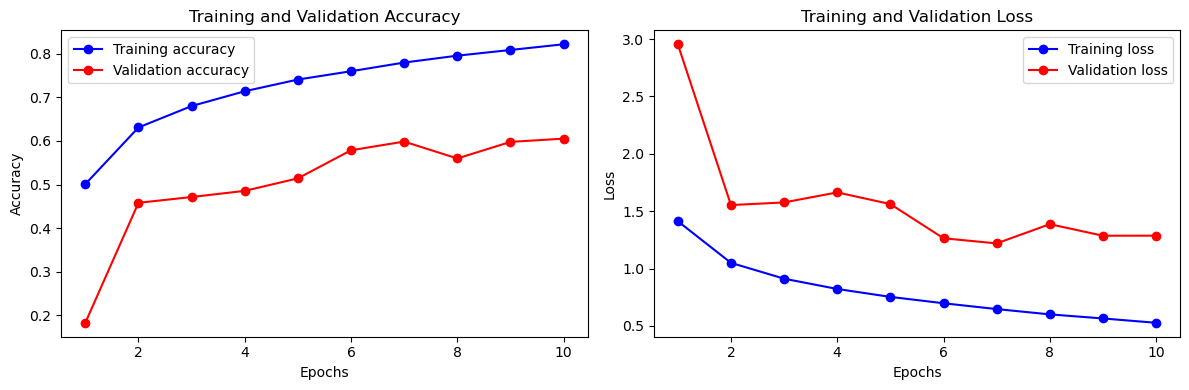

In [11]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_base)

## Hyperparameter Optimization (KerasTuner)

We use **Bayesian Optimization** to automatically search for the best combination of:
- Number of convolutional filters (`n_filters`)
- L2 regularization (`l2`)
- Learning rate (`lr`)
- Optimizer (`adam` or `sgd`)
- Dropout rate
- Activation function (`relu` or `tanh`)

KerasTuner explores multiple trials and reports the configuration with the highest validation accuracy.

In [12]:
def model_builder(hp):
    tf.keras.backend.clear_session()

    n_filters = hp.Int('n_filters', 16, 128, step=8)
    l2        = hp.Float('l2', 1e-6, 1e-2, sampling='log')
    lr        = hp.Float('lr', 1e-6, 1e-2, sampling='log')
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
    dropout   = hp.Float('dropout', 0.0, 0.7, step=0.1)
    activation= hp.Choice('activation', ['relu', 'tanh'])

    cnn = SimpleCNN()
    cnn.build(
        n_filters=n_filters,
        l2=l2,
        lr=lr,
        optimizer=optimizer_choice,
        dropout=dropout,
        activation=activation
    )
    return cnn.model

In [13]:
tuner = BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    seed=SEED,
    overwrite=True,
    directory='kt_tuner_dir',
    project_name='cifar10_cnn'
)

In [14]:
print("\n========= Starting Bayesian hyperparameter search using KerasTuner ... =========\n")
tuner.search(
    X_train, y_train,
    epochs=TUNER_EPOCHS,
    validation_data=(X_val, y_val),
    verbose=2
)

Trial 10 Complete [00h 01m 04s]
val_accuracy: 0.5278000235557556

Best val_accuracy So Far: 0.6243333220481873
Total elapsed time: 00h 09m 06s


In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
for hpname in best_hps.values.keys():
    print(f"{hpname}: {best_hps.get(hpname)}")

Best hyperparameters found:
n_filters: 80
l2: 1.8515519652548626e-06
lr: 9.775664203574933e-05
optimizer: adam
dropout: 0.6000000000000001
activation: tanh


## Final Model and Evaluation

Using the best hyperparameters found, we retrain the final CNN for 10 epochs.

We visualize:
- Accuracy and loss curves for the final model
- Example predictions
- Confusion matrix
- Full classification report (precision, recall, F1-score)

In [16]:
print("\n========= Retrain best model found by KerasTuner =========\n")
cnn_final = SimpleCNN()
cnn_final.build(
    n_filters=best_hps.get('n_filters'),
    l2=best_hps.get('l2'),
    lr=best_hps.get('lr'),
    optimizer=best_hps.get('optimizer'),
    dropout=best_hps.get('dropout'),
    activation=best_hps.get('activation')
)
history = cnn_final.fit(X_train, y_train, X_val, y_val, epochs=FINAL_EPOCHS)


========= Retrain best model found by KerasTuner =========

Epoch 1/10
274/274 - 13s - 48ms/step - accuracy: 0.2937 - loss: 2.0867 - val_accuracy: 0.2182 - val_loss: 2.5220
Epoch 2/10
274/274 - 12s - 45ms/step - accuracy: 0.3924 - loss: 1.7617 - val_accuracy: 0.4513 - val_loss: 1.5391
Epoch 3/10
274/274 - 12s - 45ms/step - accuracy: 0.4386 - loss: 1.6129 - val_accuracy: 0.5257 - val_loss: 1.3493
Epoch 4/10
274/274 - 12s - 45ms/step - accuracy: 0.4781 - loss: 1.5018 - val_accuracy: 0.5527 - val_loss: 1.2773
Epoch 5/10
274/274 - 13s - 46ms/step - accuracy: 0.5080 - loss: 1.4114 - val_accuracy: 0.5657 - val_loss: 1.2280
Epoch 6/10
274/274 - 13s - 46ms/step - accuracy: 0.5297 - loss: 1.3428 - val_accuracy: 0.5942 - val_loss: 1.1684
Epoch 7/10
274/274 - 13s - 46ms/step - accuracy: 0.5499 - loss: 1.2860 - val_accuracy: 0.6022 - val_loss: 1.1398
Epoch 8/10
274/274 - 13s - 46ms/step - accuracy: 0.5683 - loss: 1.2383 - val_accuracy: 0.6172 - val_loss: 1.1030
Epoch 9/10
274/274 - 13s - 46ms/ste

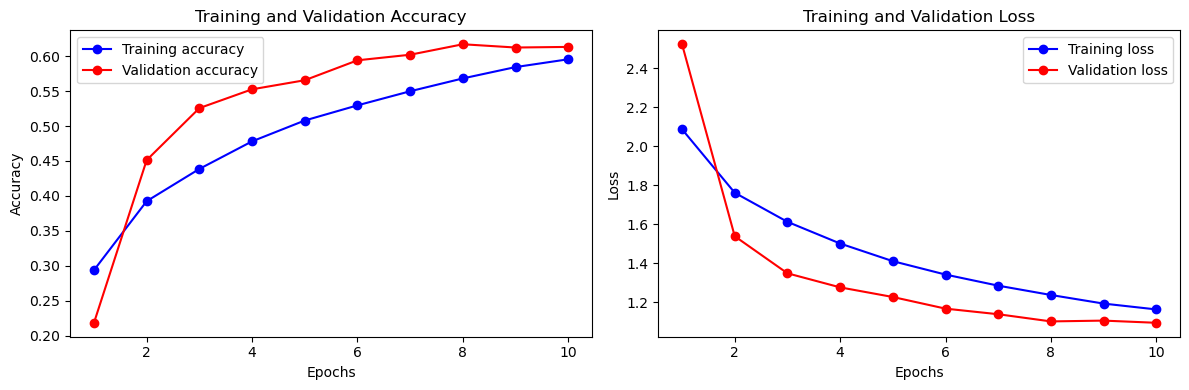

In [17]:
plot_training_history(history)

In [18]:
test_loss, test_acc = cnn_final.evaluate(X_test, y_test_onehot)
print(f"Optimized Test accuracy: {test_acc:.4f}")

Optimized Test accuracy: 0.6097


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


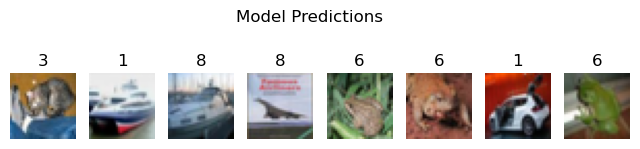

In [19]:
preds = cnn_final.model.predict(X_test)

plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(np.argmax(preds[i]))
plt.suptitle("Model Predictions")
plt.show()


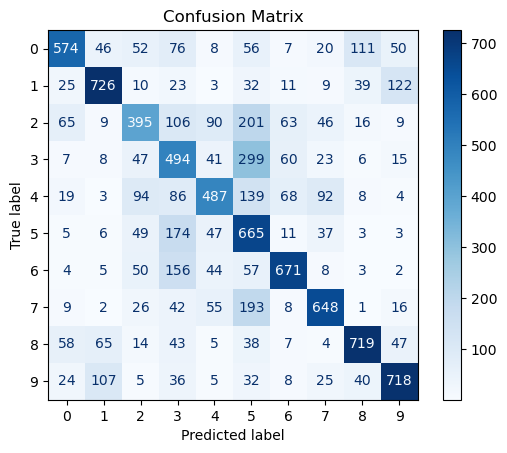

In [20]:
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(NUM_CLASSES))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.7266    0.5740    0.6413      1000
           1     0.7431    0.7260    0.7344      1000
           2     0.5323    0.3950    0.4535      1000
           3     0.3997    0.4940    0.4419      1000
           4     0.6204    0.4870    0.5457      1000
           5     0.3884    0.6650    0.4904      1000
           6     0.7341    0.6710    0.7011      1000
           7     0.7105    0.6480    0.6778      1000
           8     0.7600    0.7190    0.7390      1000
           9     0.7282    0.7180    0.7231      1000

    accuracy                         0.6097     10000
   macro avg     0.6343    0.6097    0.6148     10000
weighted avg     0.6343    0.6097    0.6148     10000



## Summary

This notebook demonstrates a reproducible and modular approach to CNN-based image classification.

✅ Implemented clean class-based model design  
✅ Integrated KerasTuner for Bayesian optimization  
✅ Produced interpretable visualizations and evaluation metrics

You can reuse this template for other datasets (e.g., Fashion-MNIST, CIFAR-100) with minimal changes.

---

© 2025 [Nicola Mustone](https://nicolamustone.blog)  
All code and notebooks are distributed under the [GNU General Public License v3.0 (GPLv3)](https://www.gnu.org/licenses/gpl-3.0.html).